# Setup

In [1]:
# BiocMa# BiocManager::install(c('BiocGenerics', 'DelayedArray', 'DelayedMatrixStats',
#                        'limma', 'S4Vectors', 'SingleCellExperiment',
#                        'SummarizedExperiment', 'batchelor'))
# devtools::install_github('cole-trapnell-lab/leidenbase')
# devtools::install_github('cole-trapnell-lab/monocle3')
# install.packages("tidyverse")
# install.packages('Seurat')
# install.packages("cowplot")

In [1]:
suppressMessages({
    library(monocle3)
    library(Seurat)
    library(tidyverse)
    library(cowplot)
    dotenv::load_dot_env()
})

# Make Merged TCells

In [2]:
PDIR = Sys.getenv("PROJECT_DIR")

In [3]:
fgid_meta = read.table(Sys.getenv("FG13metafile"), header=1) %>% 
    column_to_rownames("CellID")
cd14_meta = read.table(Sys.getenv("CD14metafile"), header=1) %>% 
    column_to_rownames("CellID")

In [5]:
FG13tcells = readRDS(file.path(PDIR,"FG13/celltype_objs/tclls_srobj.rds"))
CD14tcells = readRDS(file.path(PDIR,"CD14/celltype_objs/tclls_srobj.rds"))

FG13tcells@meta.data = fgid_meta[colnames(FG13tcells), ]
CD14tcells@meta.data = cd14_meta[colnames(CD14tcells), ]

In [6]:
Idents(CD14tcells) = "CD"
Idents(FG13tcells) = "FG"
tclls = merge(CD14tcells, FG13tcells)

In [7]:
tclls

An object of class Seurat 
42247 features across 92195 samples within 2 assays 
Active assay: SCT (18502 features, 0 variable features)
 1 other assay present: RNA

In [8]:
tclls = suppressWarnings({SCTransform(tclls, verbose=FALSE)})
tclls = RunPCA(tclls)
tclls = FindNeighbors(tclls, k.param = ceiling(0.5*sqrt(ncol(tclls))))
tclls = FindClusters(tclls)

PC_ 1 
Positive:  RPL34, RPS27, EEF1A1, RPS12, RPL32, RPL21, RPS8, RPS6, RPL13, RPL39 
	   RPL13A, RPS18, RPS15A, RPS29, RPLP2, RPS3A, RPL7, RPL41, RPS27A, RPL10 
	   CCR7, RPLP1, TPT1, RPS10, LTB, RPS4Y1, TRAC, KLF2, RPS26, TRBC2 
Negative:  GNLY, CCL4, CCL3, NKG7, GZMB, GZMA, CCL4L2, TYROBP, FCER1G, CMC1 
	   CCL5, KLRD1, IFNG, KLRF1, TRDC, AREG, XCL1, XCL2, CD69, GZMK 
	   KLRC1, CTSW, PRF1, DUSP2, CST7, IER2, FOS, HOPX, GZMH, B3GNT7 
PC_ 2 
Positive:  GNLY, GZMB, RPS27, RPS12, EEF1A1, RPS15A, RPS29, RPL34, RPL13, RPL32 
	   RPL21, RPLP2, RPS8, RPL13A, RPS6, RPL10, RPL41, RPS18, RPS3A, KLRF1 
	   RPL39, RPS27A, NKG7, TYROBP, RPS10, CMC1, RPL7, CCR7, SELL, CTSW 
Negative:  DEFA5, IGHA1, IGKC, CCL4, JCHAIN, DEFA6, APOA1, IGLC2, REG1A, FABP6 
	   JUN, CCL4L2, CD69, REG3A, APOA4, PHGR1, MT-CO1, MT-CO2, IGLC3, FOS 
	   IGHM, MT-CO3, PRAP1, HLA-DRA, PLA2G2A, APOC3, CCL3, TFF3, FABP1, IFNG 
PC_ 3 
Positive:  CCL4, CCL4L2, CCL3, CD69, IFNG, JUN, FOS, CCL5, CCL20, GZMK 
	   CCL3L3, NFKBIA, B

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 92195
Number of edges: 21834856

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8255
Number of communities: 14
Elapsed time: 221 seconds


In [11]:
tclls <- RunTSNE(tclls, 
                 initialization = FG13tcells@reductions$pca@cell.embeddings[, 1:2],
                 perplexity_list = c(30, ncol(tclls)/100),
                 learning_rate = ncol(tclls)/12,
                 exaggeration = 12,
                 dims = 1:22, 
                 fast_tsne_path = file.path(PDIR,"bin/fast_tsne"),
                 tsne.method = "FIt-SNE")

In [12]:
saveRDS(tclls, file.path(PDIR,"TcllsDeepDive/tclls_merged_srobj.rds"))

In [9]:
tclls = readRDS(file.path(PDIR,"TcllsDeepDive/tclls_merged_srobj.rds"))

In [10]:
tclls

An object of class Seurat 
42798 features across 92195 samples within 2 assays 
Active assay: SCT (19053 features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, tsne

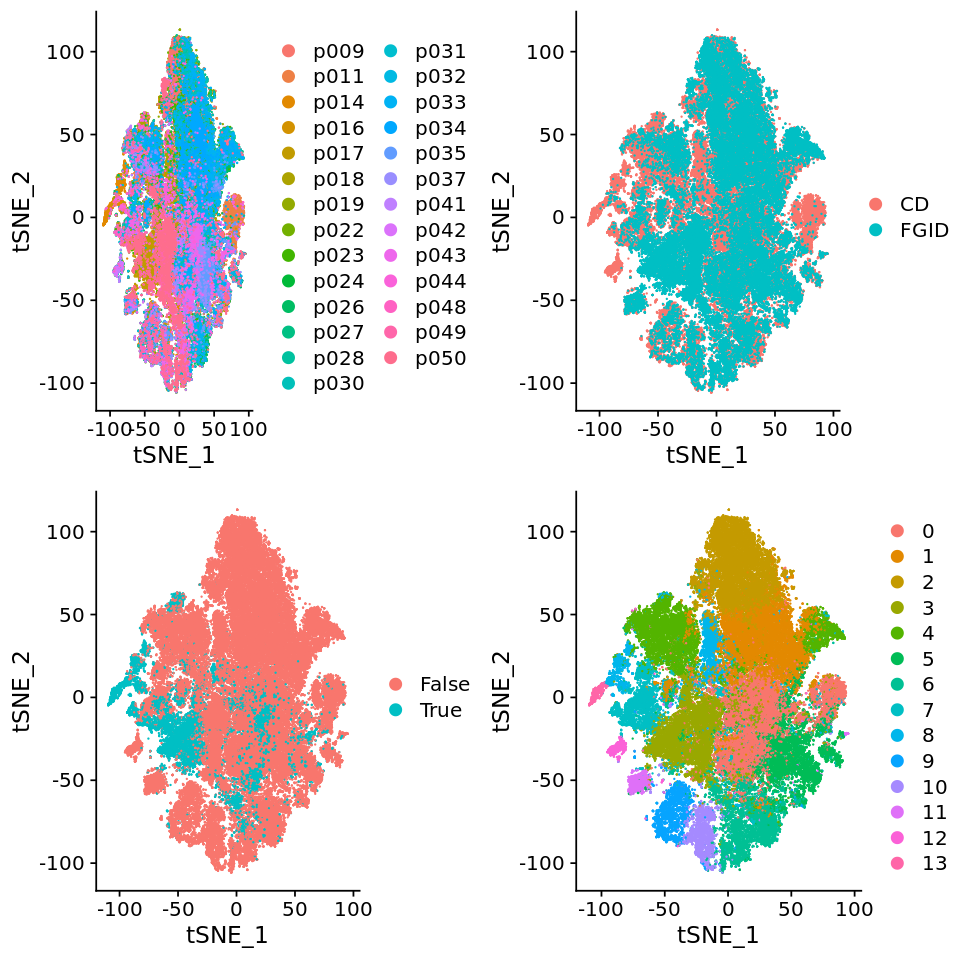

In [11]:
options(repr.plot.height = 8, repr.plot.width=8)
gridExtra::grid.arrange(DimPlot(tclls, group.by="patient"),
                  DimPlot(tclls, group.by="disease"),
                  DimPlot(tclls, group.by="is_doublet"),
                  DimPlot(tclls, group.by="seurat_clusters"),
                  ncol=2)

In [14]:
plottypes = unique(tclls$curatedname[!grepl("Doub|LowQual", tclls$type)])

# Filter

In [4]:
tclls = readRDS(file.path(PDIR,"TcllsDeepDive/tclls_merged_srobj.rds"))

In [6]:
srobj = tclls[, !grepl("Doub|LowQual", tclls$type)]

In [9]:
pltdat = srobj@meta.data %>%
    group_by(curatedname) %>%
    summarize(patsplit = length(unique(patient)),
              patginismp = 1 - sum(((table(patient)) / (length(patient)))^2),
              disease = first(disease))

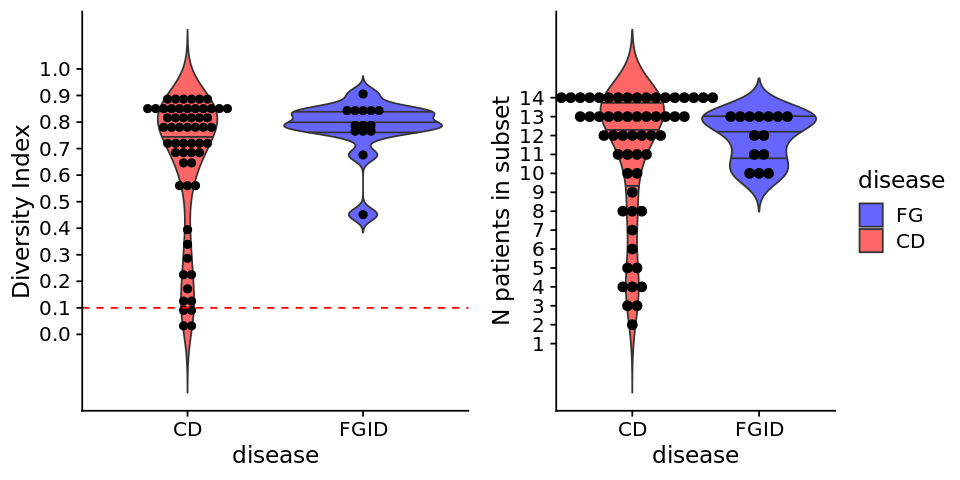

In [10]:
# patient specific?
p1 = ggplot(pltdat) +
    geom_violin(aes(y=patginismp, x=disease, fill=disease),
                trim = FALSE,
                draw_quantiles = c(0.25, 0.5, 0.75), 
                alpha=0.6) +
    geom_dotplot(aes(y=patginismp, x=disease),
                 binaxis = "y",
                 stackdir = "center",
                 binwidth=.03) +
    geom_hline(aes(yintercept=0.1), color='red', linetype=2) +
    scale_y_continuous(breaks=seq(0, 1, 0.1)) +
    ylab("Diversity Index") +
    scale_fill_manual(limits=c("FGID", "CD"),
                        labels=c("FG", "CD"),
                        values=c("#0000ff", "#ff0000")) +
    theme_cowplot()
p2 = ggplot(pltdat) +
    geom_violin(aes(y=patsplit, x=disease, fill=disease),
                trim = FALSE,
                draw_quantiles = c(0.25, 0.5, 0.75), 
                alpha=0.6) +
    geom_dotplot(aes(y=patsplit, x=disease),
                 binaxis = "y",
                 stackdir = "center",
                 binwidth=.5) +
    scale_y_continuous(breaks=1:14) +
    ylab("N patients in subset") +
    scale_fill_manual(limits=c("FGID", "CD"),
                        labels=c("FG", "CD"),
                        values=c("#0000ff", "#ff0000")) +
    theme_cowplot()
options(repr.plot.height = 4, repr.plot.width=8)
gridExtra::grid.arrange(grobs = list(p1 + NoLegend(), p2),
                        ncol=ceiling(sqrt(2)))

In [11]:
summary(pltdat$patginismp[pltdat$patsplit < 3])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03592 0.03592 0.03592 0.03592 0.03592 0.03592 

In [12]:
summary(pltdat$patsplit[pltdat$patginismp < 0.1])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   2.500   3.000   4.333   5.500   8.000 

In [13]:
pat_specific_clst = pltdat[pltdat$patginismp < 0.1,]

In [14]:
pat_specific_clst

curatedname     patsplit patginismp disease
1 CD.T.CCL20.IL22 3        0.02825397 CD     
2 CD.T.GNLY.HOPX  8        0.07676020 CD     
3 CD.T.NR3C1.CCR6 2        0.03591612 CD

In [15]:
srobj = srobj[, !(srobj$curatedname %in% pat_specific_clst)]

In [16]:
srobj

An object of class Seurat 
42798 features across 67579 samples within 2 assays 
Active assay: SCT (19053 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, tsne

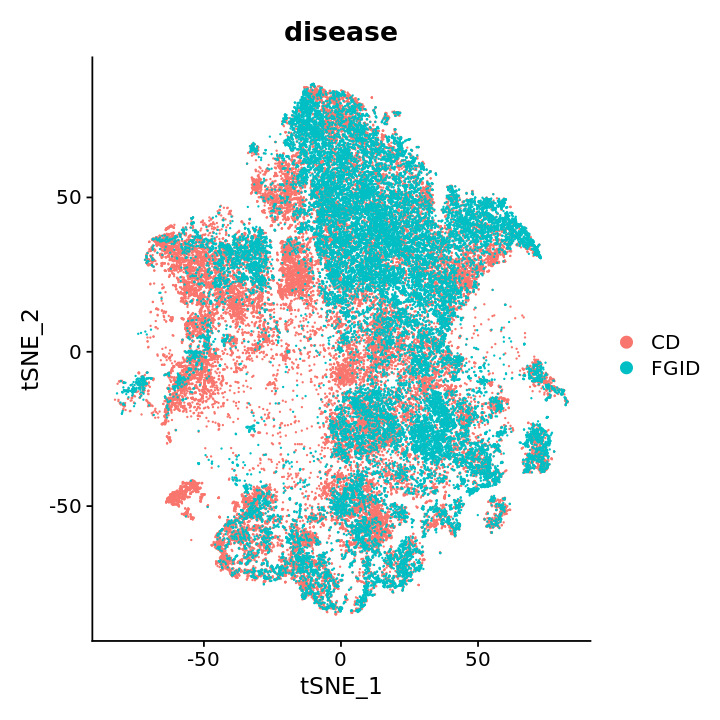

In [18]:
options(repr.plot.height = 6, repr.plot.width=6)
DimPlot(srobj, group.by="disease")

In [19]:
saveRDS(srobj, file.path(PDIR,"TcllsDeepDive/srobj_filtered_srobj.rds"))

In [20]:
srobj = readRDS(file.path(PDIR,"TcllsDeepDive/srobj_filtered_srobj.rds"))

In [21]:
srobj

An object of class Seurat 
42798 features across 67579 samples within 2 assays 
Active assay: SCT (19053 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, tsne

# Calculate Genes

In [22]:
FG13 = readRDS(Sys.getenv("FG13srobj"))
CD14 = readRDS(Sys.getenv("CD14srobj"))

In [23]:
FG13@meta.data = fgid_meta[colnames(FG13), ]

In [24]:
CD14@meta.data = cd14_meta[colnames(CD14), ]

In [25]:
# find markers for mloid against other cell types
Idents(FG13) = colnames(FG13) %in% colnames(srobj[, srobj$disease == "FGID"])
fgid_markers = FindMarkers(FG13[, !grepl("Doub|LowQual", FG13$type)  & 
                                  !(FG13$curatedname %in% pat_specific_clst)],
                           assay="RNA",
                           ident.1=TRUE, ident.2=FALSE,
                           only.pos=TRUE, test.use="wilcox",
                           max.cells.per.ident=10000)
fgid_markers %>% dim

Idents(CD14) = colnames(CD14) %in% colnames(srobj[, srobj$disease == "CD"])
cd14_markers = FindMarkers(CD14[, !grepl("Doub|LowQual", CD14$type) & 
                                 !(CD14$curatedname %in% pat_specific_clst)],
                           assay="RNA",
                           ident.1=TRUE, ident.2=FALSE,
                           only.pos=TRUE, test.use="wilcox",
                           max.cells.per.ident=10000)
cd14_markers %>% dim

[1] 570   5

[1] 810   5

In [26]:
# find disease 
Idents(srobj) = srobj$disease
disease.markers = FindMarkers(srobj, assay="RNA",
               ident.1="CD", ident.2="FGID",
               only.pos=FALSE, test.use="wilcox",
               max.cells.per.ident=10000)

In [27]:
nrow(disease.markers)

[1] 115

In [28]:
psuedotime_genes = unique(rownames(fgid_markers), rownames(cd14_markers)) %>%
    .[!(. %in% rownames(disease.markers))]

In [29]:
srobj@misc$pseudotime_genes = psuedotime_genes

In [31]:
srobj@misc$pseudotime_genes %>% length

[1] 522

In [32]:
saveRDS(srobj, file.path(PDIR,"TcllsDeepDive/srobj_filtered_calcGenes.rds"))

# Get umap

In [58]:
srobj = readRDS(file.path(PDIR,"TcllsDeepDive/srobj_filtered_calcGenes.rds"))

In [33]:
srobj = ScaleData(srobj, assay = "RNA", features=srobj@misc$pseudotime_genes)
srobj = RunPCA(srobj, assay="RNA", 
       features=srobj@misc$pseudotime_genes,
       reduction.name="pca_coregenes", reduction.key = "PCcore_")

Centering and scaling data matrix

PCcore_ 1 
Positive:  MALAT1, CCL4, CCL5, GZMK, CTD-3252C9.4, DUSP2, PTPRC, CD69, CLDND1, SRSF7 
	   SYNE2, RSRP1, DNAJA1, RORA, ADGRE5, MCL1, PPP1R15A, LCP1, RP11-138A9.1, KLF6 
	   IQGAP1, SF3B1, PIK3R1, AREG, GPR65, TIGIT, MYADM, RNF19A, TSPYL2, DDX3X 
Negative:  RPS12, RPL32, RPS18, RPS15A, RPL13, RPL21, RPL13A, RPS8, RPL39, RPS6 
	   RPS14, RPLP2, RPL41, RPS27A, RPL11, RPS25, RPL23A, RPL31, RPL35A, RPL19 
	   RPS3, RPS13, RPL30, RPL10, RPL9, RPS4X, RPL7, RPS16, RPL3, RPL36 
PCcore_ 2 
Positive:  RPL32, MALAT1, RPS6, RPL21, RPL13, RPS8, RPL39, RPLP2, RPS12, RPL13A 
	   RPS15A, RPS18, RPS13, RPL11, RPS25, RPS27A, RPL37, RPS14, RPL35A, RPL30 
	   KLF2, RPL9, RPL31, RPL38, RPL19, RPL7, RPL5, RPL3, RPL36, RPS21 
Negative:  SRGN, H3F3B, CD69, CCL5, DUSP2, PFN1, ZFP36, MCL1, NFKBIA, TNFAIP3 
	   DNAJA1, EIF1, MYL12A, KLRB1, KLF6, DDX5, HLA-E, TMSB4X, PPP1R15A, ITM2B 
	   NR4A2, SAMSN1, CKLF, YPEL5, SRSF2, COTL1, BTG2, CCL4, GPR65, CYCS 
PCcore_ 3 
Posit

In [34]:
srobj = RunUMAP(srobj, assay="RNA", 
        reduction="pca_coregenes", dims=1:50,
        n.neighbors=54, min.dist=0.1, #ceiling(0.5*sqrt(ncol(srobj))),
        verbose=FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


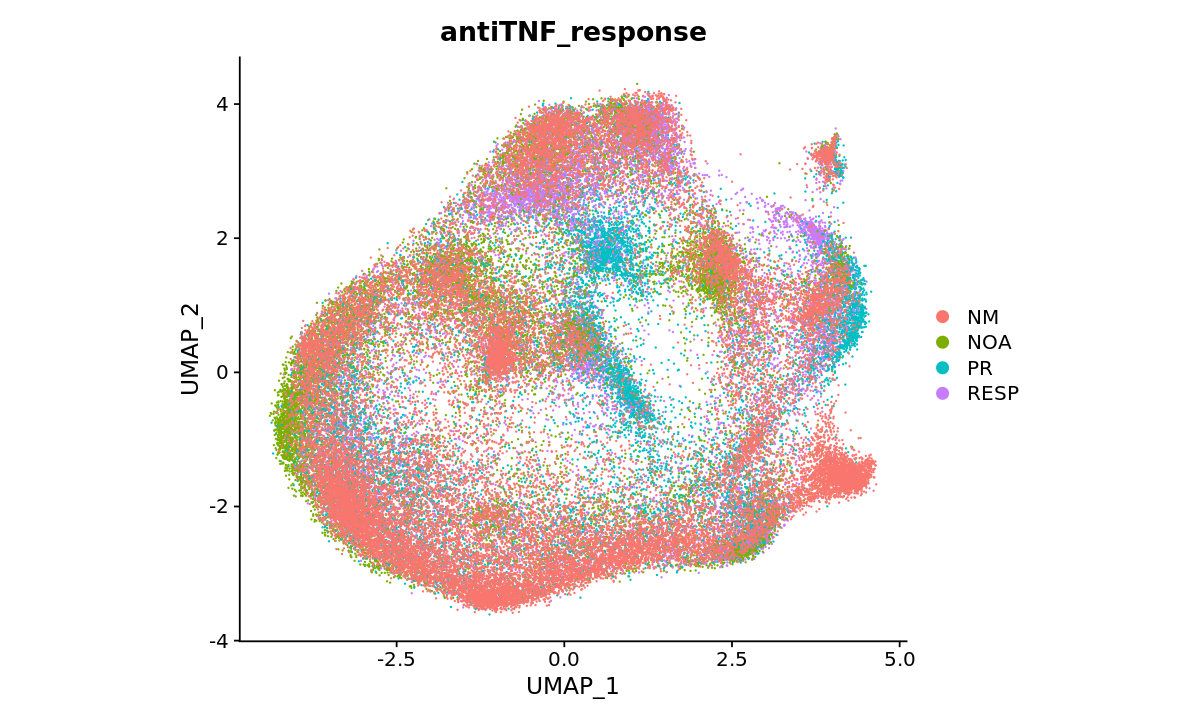

In [35]:
options(repr.plot.height=6, repr.plot.width=10)
DimPlot(srobj, reduction="umap", label = FALSE,group.by="antiTNF_response")+
#     NoLegend()+
    coord_fixed()

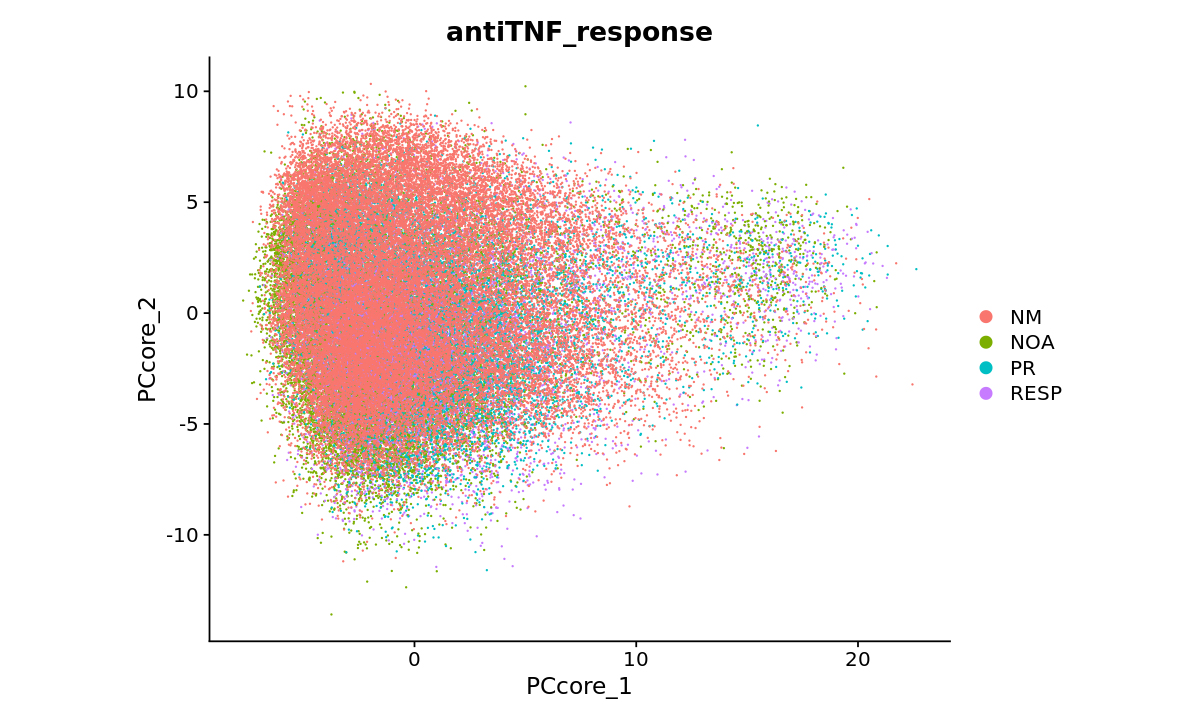

In [36]:
DimPlot(srobj, reduction="pca_coregenes", label = FALSE,group.by="antiTNF_response")+
#     NoLegend()+
    coord_fixed()

In [53]:
srobj$umapXs = srobj@reductions$umap@cell.embeddings[,"UMAP_1"]
srobj$umapYs = srobj@reductions$umap@cell.embeddings[,"UMAP_2"]

In [38]:
srobj$pc1 = srobj@reductions$pca_coregenes@cell.embeddings[,"PCcore_1"]
srobj$pc2 = srobj@reductions$pca_coregenes@cell.embeddings[,"PCcore_2"]

# Make monocle object

In [65]:
srobj = readRDS(file.path(PDIR,"TcllsDeepDive/srobj_filtered_calcGenes.rds"))

In [39]:
# tclls = srobj[, srobj$is_mphage] # & !srobj$is_mphage_chemo]

srobj@assays$SCT@meta.features$gene_short_name = rownames(srobj@assays$SCT@meta.features)
srobj@assays$RNA@meta.features$gene_short_name = rownames(srobj@assays$RNA@meta.features)
srobj@assays$RNA@counts %>% colnames %>% length
srobj@meta.data %>% rownames %>% head

cds <- new_cell_data_set(srobj@assays$RNA@counts,
                         cell_metadata = srobj@meta.data,
                         gene_metadata = srobj@assays$RNA@meta.features)

[1] 67579

[1] "p011_T0D_ILE_LPS_3p_AAACCTGAGAGTCTGG-1"
[2] "p011_T0D_ILE_LPS_3p_AAACCTGAGTGGACGT-1"
[3] "p011_T0D_ILE_LPS_3p_AAACCTGCACACTGCG-1"
[4] "p011_T0D_ILE_LPS_3p_AAACGGGAGAGTGACC-1"
[5] "p011_T0D_ILE_LPS_3p_AAACGGGAGGACGAAA-1"
[6] "p011_T0D_ILE_LPS_3p_AAACGGGAGGTGGGTT-1"

In [40]:
table(srobj$disease)


   CD  FGID 
38181 29398 

In [41]:
cds

class: cell_data_set 
dim: 23745 67579 
metadata(1): cds_version
assays(1): counts
rownames(23745): RP11-34P13.7 FO538757.2 ... RP4-539M6.14 RP4-569D19.8
rowData names(1): gene_short_name
colnames(67579): p011_T0D_ILE_LPS_3p_AAACCTGAGAGTCTGG-1
  p011_T0D_ILE_LPS_3p_AAACCTGAGTGGACGT-1 ...
  p050_T0D_ILE_LPS_3p_TTTGTCACATAGGATA-1
  p050_T0D_ILE_LPS_3p_TTTGTCATCAGAAATG-1
colData names(41): cluster orig_idx ... pc2 Size_Factor
reducedDimNames(0):
altExpNames(0):

In [42]:
cds <- preprocess_cds(cds, method="PCA", num_dim = 50, use_genes=srobj@misc$pseudotime_genes)
# cds <- preprocess_cds(cds, method="LSI", num_dim = 45, use_genes=markers_allmphage_againstall)
# cds <- align_cds(cds, preprocess_method = "LSI", alignment_group = "disease")

In [43]:
reducedDims(cds)

List of length 1
names(1): PCA

In [44]:
round(10^seq(-2, 0, 0.2),digits=2)

[1] 0.01 0.02 0.03 0.04 0.06 0.10 0.16 0.25 0.40 0.63 1.00

In [45]:
ceiling(0.5*sqrt(ncol(tclls)))

[1] 152

In [46]:
umapcoords = data.table::rbindlist(lapply(round(10^seq(-2, 0, 0.2),digits=2), 
                                          function(md) {
    cds <- reduce_dimension(cds, cores=10,
                        umap.n_neighbors = ceiling(0.5*sqrt(ncol(tclls))), 
                        umap.min_dist = md,
                        preprocess_method="PCA", 
                        max_components=2)
    data.frame(
        cellID = colnames(cds),
        mindist=md,
        TNFR = cds$antiTNF_response,
        umapX = reducedDims(cds)[["UMAP"]][, 1],
        umapY = reducedDims(cds)[["UMAP"]][, 2]
        )
}))

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'

Note: reduce_dimension will

In [47]:
saveRDS(umapcoords, file.path(PDIR,"TcllsDeepDive/umapcoords.rds"))

In [48]:
dim(umapcoords)

[1] 743369      5

In [49]:
tail(umapcoords)

cellID                                 mindist TNFR umapX     umapY    
1 p050_T0D_ILE_LPS_3p_TTTGCGCGTTCCGGCA-1 1       NM   -6.491460 0.9664511
2 p050_T0D_ILE_LPS_3p_TTTGCGCTCAGCACAT-1 1       NM   -3.146069 2.2475713
3 p050_T0D_ILE_LPS_3p_TTTGGTTAGAGTACCG-1 1       NM   -5.274635 1.5783156
4 p050_T0D_ILE_LPS_3p_TTTGTCAAGAATTCCC-1 1       NM   -6.634093 1.4995937
5 p050_T0D_ILE_LPS_3p_TTTGTCACATAGGATA-1 1       NM   -2.491475 3.8722509
6 p050_T0D_ILE_LPS_3p_TTTGTCATCAGAAATG-1 1       NM   -6.317701 1.2198065

In [50]:
cds <- reduce_dimension(cds, cores=10,
                        umap.n_neighbors = ceiling(0.5*sqrt(ncol(tclls))), 
                        umap.min_dist = 0.1,
                        preprocess_method="PCA", 
                        max_components=2)

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'



  |======================================================================| 100%


Warning message:
“`select_()` was deprecated in dplyr 0.7.0.
Please use `select()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


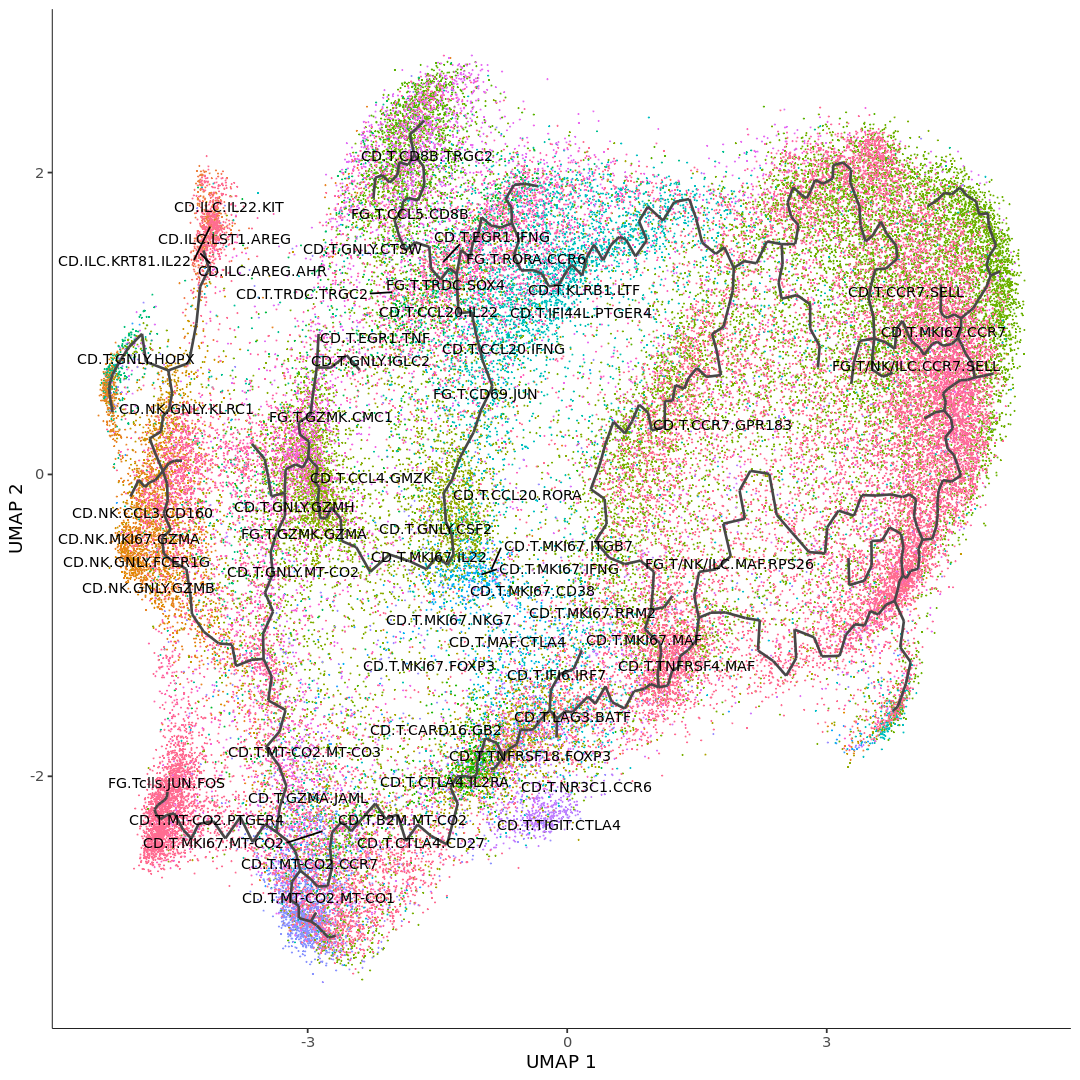

In [51]:
options(repr.plot.width=9, repr.plot.height=9)
cds <- cluster_cells(cds, cores=10)
cds <- learn_graph(cds, use_partition = FALSE, learn_graph_control = list(minimal_branch_len = 10))
plot_cells(cds, #reduction_method = "PCA",
           color_cells_by = "curatedname",
           label_groups_by_cluster=FALSE,
           label_leaves=FALSE,
           group_label_size=3,
           label_branch_points=FALSE)

In [52]:
srobj$umapX = reducedDims(cds)[["UMAP"]][, 1]
srobj$umapY = reducedDims(cds)[["UMAP"]][, 2]

In [54]:
saveRDS(srobj, file.path(PDIR,"TcllsDeepDive/srobj_calcUMAP.rds"))

# plot density

In [9]:
get_contour = function(df) {
    fhat = ks::kde(df[, c("x", "y")], compute.cont=TRUE)
    dimnames(fhat[['estimate']]) <- list(fhat[["eval.points"]][[1]],
                                         fhat[["eval.points"]][[2]])
    contours = reshape2::melt(fhat[["estimate"]])
    contours$quantile = fhat[["cont"]]["5%"]
    return(contours)
}

hpd_contour <- function (x, n = 50, prob = 0.95, ...) {
  post1 <- MASS::kde2d(x[[1]], x[[2]], n = n, ...)

  dx <- diff(post1$x[1:2])
  dy <- diff(post1$y[1:2])
  sz <- sort(post1$z)
  c1 <- cumsum(sz) * dx * dy

  levels <- sapply(prob, function(x) {
    approx(c1, sz, xout = 1 - x)$y
  })

  return(data.table::rbindlist(
      grDevices::contourLines(post1$x, post1$y, post1$z, levels = levels), idcol="sbgrp"))
}

# fhat = ks::kde(d[, c("x", "y")], compute.cont=TRUE)
# dimnames(fhat[['estimate']]) <- list(fhat[["eval.points"]][[1]], fhat[["eval.points"]][[2]])
# aa = reshape2::melt(fhat[["estimate"]])

In [10]:
hellinger2d = function(psmp, qsmp, bgridsize=rep(100, dim(qsmp)[2])) {
#     if (dim(psmp)[2] != dim(qsmp)[2]) {
#         error("dimensions must be equal!")
#     }
    psmp = as.matrix(psmp)
    qsmp = as.matrix(qsmp)
    smp = rbind(psmp, qsmp)
#     K = dim(psmp)[2]
    
    mins = colMins(smp)
    maxs = colMaxs(smp)
    H = ks::Hpi(smp)
    
    phat = ks::kde(psmp,
                   H=H, 
                   bgridsize=bgridsize, 
                   xmin=mins, xmax=maxs, 
                   compute.cont=FALSE,
                   approx.cont=FALSE)$estimate
    qhat = ks::kde(qsmp, 
                   H=H, 
                   bgridsize=bgridsize, 
                   xmin=mins, xmax=maxs, 
                   compute.cont=FALSE,
                   approx.cont=FALSE)$estimate
    
    ps = round(phat, digits=15)
    ps = ps / sum(ps) # make sum to 1
    
    qs = round(qhat, digits=15)
    qs = qs / sum(qs) # make sum to 1
    
    return(
        sqrt(1 - sum(sqrt(ps*qs)))
    )
}

In [511]:
# Start the clock!
ptm <- proc.time()
for (i in 1:10) {
hellinger2d(psmp, qsmp)
}
proc.time() - ptm

   user  system elapsed 
  8.116   0.004   8.122 

In [521]:
combn(c("NM", "NOA", "RESP", "PR"),2, simplify = FALSE)

[[1]]
[1] "NM"  "NOA"

[[2]]
[1] "NM"   "RESP"

[[3]]
[1] "NM" "PR"

[[4]]
[1] "NOA"  "RESP"

[[5]]
[1] "NOA" "PR" 

[[6]]
[1] "RESP" "PR"

In [110]:
test.dists = data.table::rbindlist(lapply(combn(c("NM", "NOA", "RESP", "PR"),2, simplify=FALSE), function(grp) {
    data.frame(grp1=grp[1],
               grp2=grp[2],
               dist=hellinger2d(
                    psmp=srobj@meta.data[srobj$antiTNF_response == grp[1], c("umapX", "umapY")],
                    qsmp=srobj@meta.data[srobj$antiTNF_response == grp[2], c("umapX", "umapY")]
               ))
}))

In [111]:
test.dists %>% arrange(dist)

grp1 grp2 dist     
1 NM   NOA  0.3963051
2 NOA  RESP 0.4197339
3 NM   RESP 0.4499656
4 RESP PR   0.4515140
5 NOA  PR   0.5359993
6 NM   PR   0.5536194

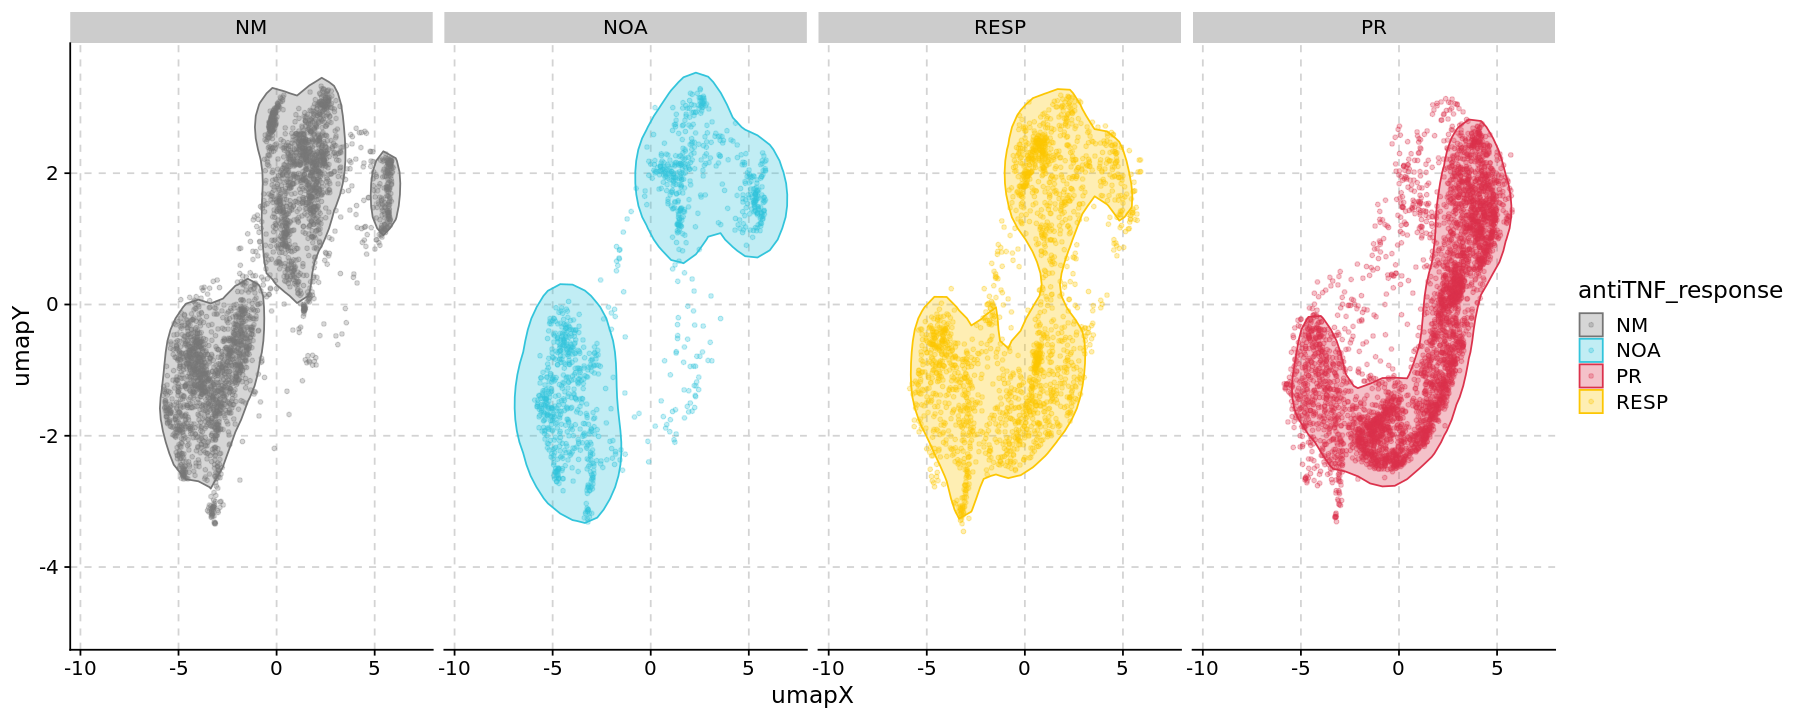

In [226]:
xnudge=2.8
ynudge=1.4

clines = data.frame(umapX=srobj$umapX,
                    umapY=srobj$umapY,
                    antiTNF_response=factor(srobj$antiTNF_response)) %>% 
  group_by(antiTNF_response) %>% 
  do(hpd_contour(.[, c("umapX", "umapY")], 
                 prob=0.8,
                 lims=c(c(range(min(srobj$umapX):max(srobj$umapX)))*xnudge,
                        c(range(min(srobj$umapY):max(srobj$umapY)))*ynudge)))

disease.severity.colors = c("NM"="#757575","NOA"="#32c4db","PR"="#db324c","RESP"="#fcc603")
options(repr.plot.width=15, repr.plot.height=6)

ggplot(srobj@meta.data, 
       aes(x=umapX, y=umapY, color=antiTNF_response)) + 
    cowplot::theme_cowplot() + 
    theme(panel.grid.major=element_line(linetype="dashed",color="lightgrey")) +
#     stat_density_2d(aes(fill=antiTNF_response), geom="polygon", alpha=.3, bins=10) +
    geom_polygon(data=clines, aes(x=x, y=y,subgroup=sbgrp,fill=antiTNF_response), alpha=.3) +
    geom_point(size=1, alpha=.3) +
    xlim(c(range(min(srobj$umapY):max(srobj$umapY)))*xnudge) + 
    ylim(c(range(min(srobj$umapY):max(srobj$umapY)))*ynudge) +
    facet_grid(.~factor(antiTNF_response, levels=c("NM", "NOA", "RESP", "PR"))) +
    scale_color_manual(values=disease.severity.colors) +
    scale_fill_manual(values=disease.severity.colors)
    

In [63]:
saveRDS(srobj, file.path(PDIR,"TcllsDeepDive/srobj_calcUMAP"))

In [64]:
srobj = readRDS(file.path(PDIR,"TcllsDeepDive/srobj_calcUMAP"))